In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import dxpy
import os


# Path depending which laptop I am using
PATH = '/home/adriana/Projects/CNV/230404-fold80-investigation/gCNV-validation'
#PATH = '/Users/adriana/Projects/cnv/gCNV-validation'

In [8]:
# Find all 002_ CEN projects
project_ids = []
projects=dxpy.bindings.search.find_projects(name="002_*A*_CEN",name_mode="glob",describe=True)
for project in projects:
    project_ids.append(project['describe']['id'])

print(project_ids)
print(len(project_ids))

['project-GQqFYP04FyK3v1QJQ0K9F6Fg', 'project-GQqFYVQ45y965gz5kGfQ4Qbk', 'project-GQj2KjQ411f82bFvvxFQ50zK', 'project-GQj2PkQ4b1b2KpfjzGK4yG5z', 'project-GP2VQ5Q4JFY0pPYQKK9p0xzV', 'project-GKGBQf846kVj6KqxGfYp2jQg', 'project-GBkKPvQ4kYyF88304g4fzbYv', 'project-GF62QG045V8k6qX5F5gXXJV7', 'project-G9pZGj04PxP8Jv1j7gp0Bz4j', 'project-G9B06xQ4543zy86jFVPGBq30', 'project-G6BQjgj4XzJvbF7FBGGz2QQx', 'project-GBVYxQQ4bkqJ0q1764J094jB', 'project-GFP6yV84gbGBJ79jK820j2zV', 'project-GBvjbPj4byJk4Zx64x3ffj9p', 'project-GFzp36j4b2B200PVBbXv4792', 'project-GFBYVP04bvX5YxP0BVGg1jQb', 'project-G8x16Qj4J3y97bvV75Y8v0Jz', 'project-GB6V8xj4j3770QYFGf2G6Xyj', 'project-G91X7504bVB2809Q0YjVv4kX', 'project-G5fg0p04020pjQqpBPqzB2Fy', 'project-G7Q08yj4j0kKGpYj4YpgQpYf', 'project-G9bqygj4p95kxF1Q4VZ2v645', 'project-GB6V7404vb5b5jyXJzVPG764', 'project-GP2XVqj4fJ899f193GY1g8p0', 'project-GK4K0bj4zpvF9062PJ56bKk5', 'project-GQ5f2z04vFb3XzFvY181Yx63', 'project-GFjK5j04yB1jvy037Zx0yfg7', 'project-GQ5fKY049kZJf8y0Xj

In [ ]:
# Download all HsMetrics files from all projects (only live files)
for project in project_ids:
    project_name=dxpy.api.project_describe(project)['name'][4:33]
    #print(project_name)
    hs_metrics = list(dxpy.bindings.search.find_data_objects(classname="file",describe=True, project=project,name="multiqc_picard_HsMetrics.txt",name_mode="exact"))
    live_files=[x for x in hs_metrics if x['describe']['archivalState'] == 'live']

    if live_files:
        dxpy.bindings.dxfile_functions.download_dxfile(live_files[0]['id'],filename=f'{project_name}-hs-metrics.txt',project=project)

In [9]:
# Concatenate all HsMetrics files into one dataframe

data=pd.DataFrame()
for filename in os.listdir(PATH):
    if filename.endswith("hs-metrics.txt"):
        run_name=filename[:-15]
        tmp_df=pd.read_csv(f'{PATH}/{filename}', sep='\t')
        tmp_df['Run']=run_name
        data = pd.concat([data,tmp_df])

In [11]:
# View runs within this dataset
data.Run.unique()

array(['230223_A01295_0161_BHVH73DRX2', '221003_A01295_0126_AHKFWYDRX2',
       '230113_A01303_0141_BHKTKKDRX2', '230223_A01295_0160_AHVLMJDRX2',
       '230209_A01295_0154_AHVJJNDRX2', '221212_A01303_0128_BHMKLWDRX2',
       '221130_A01303_0124_AHMTC5DRX2', '230113_A01303_0140_AHKVC7DRX2',
       '220825_A01295_0122_BH7WG5DRX2', '211013_A01303_0032_BHLF3JDRXY',
       '220920_A01303_0099_AHGNJNDRX2', '230309_A01303_0164_BHWF2CDRX2',
       '230406_A01295_0174_BH3VTFDRX3', '220204_A01295_0053_BHYKH3DRXY',
       '220805_A01303_0087_BH7HGVDRX2', '221124_A01295_0138_BHMTHGDRX2',
       '230209_A01295_0155_BHVLL7DRX2', '220907_A01295_0125_BHGNF3DRX2',
       '221101_A01303_0112_AHKG5WDRX2', '230411_A01303_0180_AH3VYTDRX3',
       '230406_A01295_0173_AH3WCGDRX3', '221130_A01303_0125_BHMW7LDRX2',
       '220425_A01303_0064_AH3WH7DRX2', '230309_A01303_0163_AHWC7VDRX2',
       '221019_A01295_0131_AHKFHHDRX2', '221028_A01295_0133_BHKFHYDRX2',
       '220301_A01295_0062_BHYKG5DRXY', '220221_A01

(1483, 62)

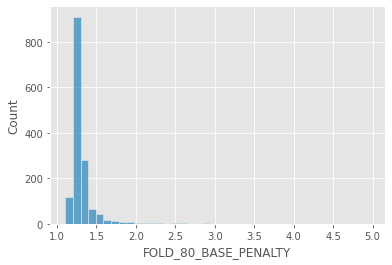

In [12]:
plt.style.use('ggplot')
sns.histplot(data=data.FOLD_80_BASE_PENALTY,bins=40)

data.shape


<AxesSubplot:xlabel='FOLD_80_BASE_PENALTY', ylabel='Count'>

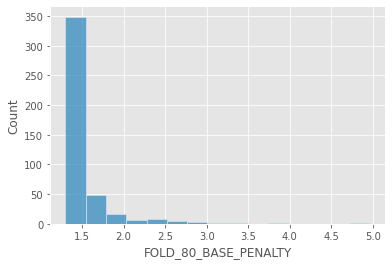

In [13]:
plt.style.use('ggplot')
above_cutoff=data.loc[data['FOLD_80_BASE_PENALTY']>1.3]
sns.histplot(data=above_cutoff.FOLD_80_BASE_PENALTY,bins=15)
#plt.ayhline(x=1.3,color='r',linestyle='--')

In [14]:
print(len(list(data.Run.unique())))
above_cutoff_high=data.loc[data['FOLD_80_BASE_PENALTY']>1.5]

print(len(list(above_cutoff_high.Run.unique())))
print(len(list(above_cutoff.Run.unique())))

31
25
31


<AxesSubplot:xlabel='FOLD_80_BASE_PENALTY', ylabel='Count'>

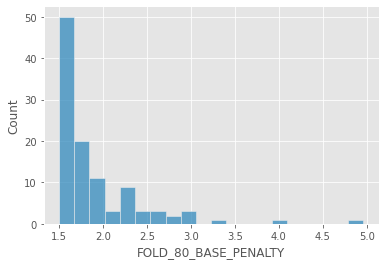

In [15]:
sns.histplot(data=above_cutoff_high.FOLD_80_BASE_PENALTY,bins=20)


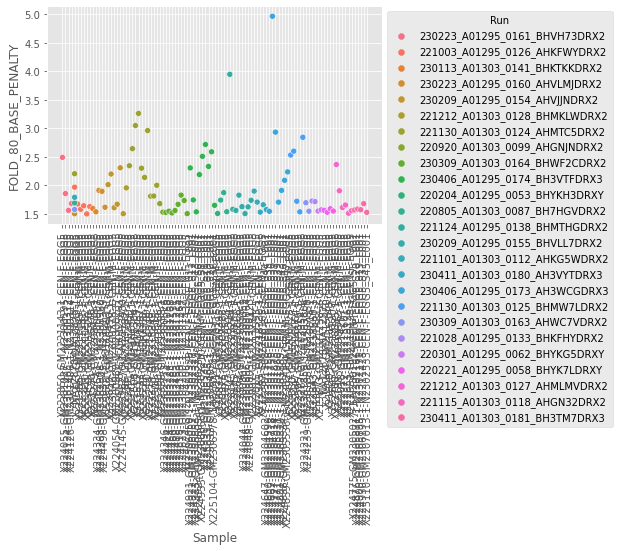

In [16]:
ax=sns.scatterplot(x='Sample', y='FOLD_80_BASE_PENALTY', hue='Run', data=above_cutoff_high)
sns.move_legend(ax, 'upper left',bbox_to_anchor=(1,1))
labels=plt.xticks(rotation=90)

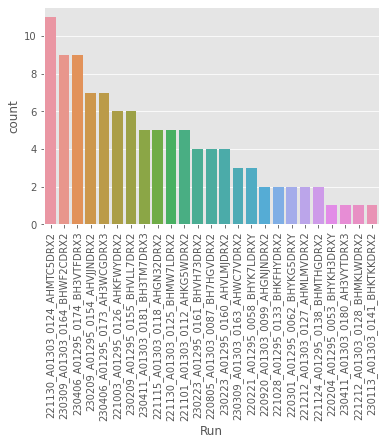

In [17]:
sns.countplot(x='Run', data=above_cutoff_high,order=above_cutoff_high['Run'].value_counts().index)
x=plt.xticks(rotation=90)

In [18]:
above_cutoff_high[above_cutoff_high.Sample.str.startswith('X224279')].FOLD_80_BASE_PENALTY


16    1.537622
Name: FOLD_80_BASE_PENALTY, dtype: float64

## Investigate in conjuction with gcnv.bed

Downloaded and unziped following file for run 124 file-GP6X5484GxyxP0JY5V9j2pY5


In [20]:
gcnv_124=pd.read_csv(f'{PATH}/002_221130_A01303_0124_AHMTC5DRX2_CEN_copy_ratios-chr20.gcnv.bed', sep='\t')
chr20_gcnv_mean = gcnv_124.mean().drop(['chr','start','end']).to_frame(name='CP_mean')


In [21]:
subset124=data[data.Run=='221130_A01303_0124_AHMTC5DRX2'][['Sample','FOLD_80_BASE_PENALTY', 'HS_PENALTY_20X', 'HS_PENALTY_30X', 'HS_PENALTY_40X', 'HS_PENALTY_50X',
       'HS_PENALTY_100X']].sort_values(by=['FOLD_80_BASE_PENALTY'],ascending=False).set_index('Sample')

In [22]:
combined = chr20_gcnv_mean.join(subset124, how='inner')

In [23]:
combined.sort_values(by=['FOLD_80_BASE_PENALTY'])

,CP_mean,FOLD_80_BASE_PENALTY,HS_PENALTY_20X,HS_PENALTY_30X,HS_PENALTY_40X,HS_PENALTY_50X,HS_PENALTY_100X
X222221-GM2217068-1-CEN-F-EGG5,1.975728,1.215692,5.434159,5.444948,5.458434,5.472999,5.544205
X222323-GM2216623-1-CEN-F-EGG5,2.024732,1.220516,5.441134,5.459324,5.468419,5.488429,5.561191
X222213-gm2215169-1-CEN-F-EGG5,1.984771,1.226617,5.696014,5.713346,5.730679,5.754945,5.838141
X222123-GM2215552-1-CEN-F-EGG5,2.000408,1.227307,5.542668,5.567850,5.580441,5.600084,5.684697
X222227-GM2215487-1-CEN-F-EGG5,1.995213,1.227655,5.429066,5.442529,5.462723,5.480225,5.566389
X222273-GM2215540-1-CEN-F-EGG5,2.012655,1.227752,5.355542,5.368156,5.393385,5.408522,5.499345
X222209-GM2216214-1-CEN-F-EGG5,1.987241,1.239794,5.414127,5.433023,5.459477,5.475350,5.575121
X222342-GM2215770-1-CEN-F-EGG5,1.974413,1.240729,5.386772,5.400628,5.417949,5.436656,5.519796
X222324-GM2216503-1-CEN-F-EGG5,1.991049,1.241067,5.576871,5.594889,5.621915,5.638131,5.753443
X222326-GM2215883-1-CEN-F-EGG5,2.010626,1.243945,5.543060,5.564263,5.581225,5.601579,5.723706


<AxesSubplot:xlabel='CP_mean', ylabel='FOLD_80_BASE_PENALTY'>

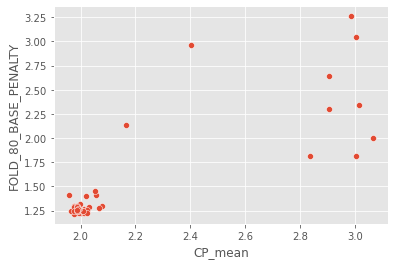

In [24]:
sns.scatterplot(data=combined,x=combined.CP_mean,y=combined.FOLD_80_BASE_PENALTY)

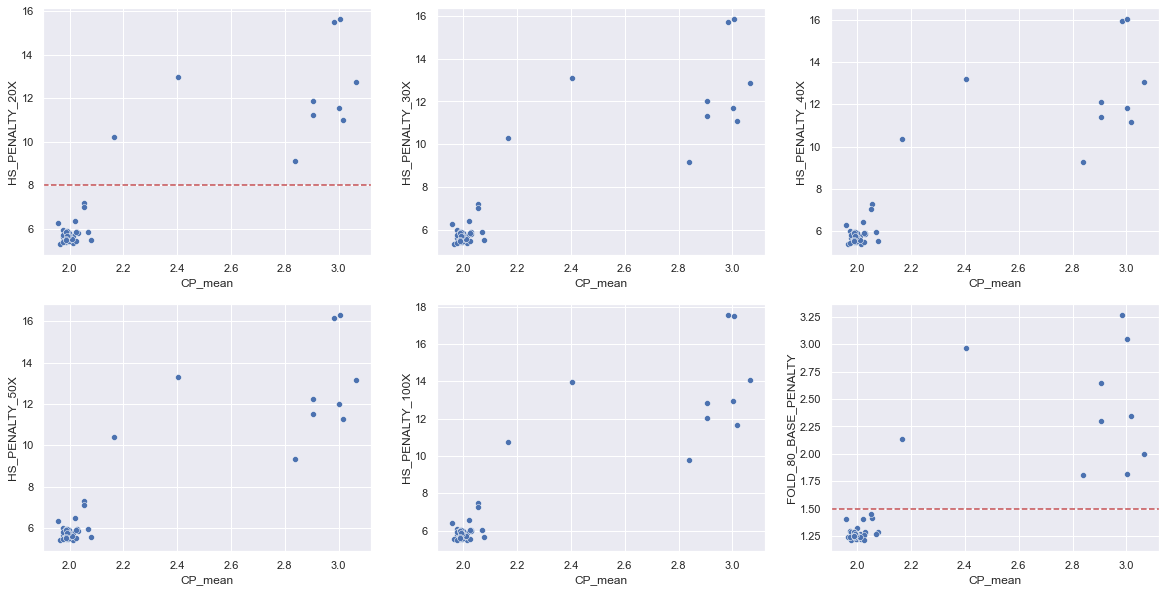

In [26]:
sns.set()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,10)
sns.scatterplot(ax=axs[0,0],data=combined,x=combined.CP_mean,y=combined.HS_PENALTY_20X)
sns.scatterplot(ax=axs[0,1],data=combined,x=combined.CP_mean,y=combined.HS_PENALTY_30X)
sns.scatterplot(ax=axs[0,2],data=combined,x=combined.CP_mean,y=combined.HS_PENALTY_40X)
sns.scatterplot(ax=axs[1,0],data=combined,x=combined.CP_mean,y=combined.HS_PENALTY_50X)
sns.scatterplot(ax=axs[1,1],data=combined,x=combined.CP_mean,y=combined.HS_PENALTY_100X)
sns.scatterplot(ax=axs[1,2],data=combined,x=combined.CP_mean,y=combined.FOLD_80_BASE_PENALTY)

axs[1,2].axhline(y=1.5,color='r',linestyle='--')
axs[0,0].axhline(y=8,color='r',linestyle='--')

In [39]:
gcnv_124_all=pd.read_csv(f'{PATH}/002_221130_A01303_0124_AHMTC5DRX2_CEN_copy_ratios.gcnv.bed', sep='\t',skiprows=1)


,chr,start,end,X221539-GM1610658-1-CEN-M-EGG5,X221543-GM1701755-1-CEN-F-EGG5,X221505-GM1401654-1-CEN-M-EGG5,X221491-GM1112489-1-CEN-F-EGG5,X221512-GM1414267-1-CEN-F-EGG5,X221508-GM1406304-1-CEN-F-EGG5,X221577-GM1818200-1-CEN-F-EGG5,...,X222339-GM2216396-1-CEN-M-EGG5,X222370-GM2215849-1-CEN-M-EGG5,X222373-GM2215600-1-CEN-F-EGG5,X222463-GM2215636-1-CEN-M-EGG5,X222407-GM2215645-1-CEN-F-EGG5,X222451-GM2216324-1-CEN-F-EGG5,X222462-GM2216349-1-CEN-M-EGG5,X222479-GM2117846-1-CEN-F-EGG5,X222464-GM2216517-1-CEN-F-EGG5,X222500-GM2215615-1-CEN-M-EGG5
0,1,7917093,7917213,2.272676,2.072277,1.653570,2.030866,2.175876,1.866510,2.211151,...,2.086684,2.156853,2.042240,2.068297,2.095992,1.978667,2.085506,1.982157,1.748800,3.177000
1,1,10566155,10566275,2.018823,1.878951,2.070031,2.071546,2.121656,2.042692,2.031584,...,1.878848,1.949371,1.943195,2.212484,1.867671,2.052794,1.889546,1.833877,2.168555,2.025612
2,1,17345175,17345329,1.805859,1.983183,1.966795,2.012465,1.944273,2.097837,2.017081,...,1.937739,1.961396,2.078843,2.207391,2.021491,2.139737,1.981838,2.013703,2.030879,1.981197
3,1,17345329,17345483,2.006183,2.138546,2.090473,1.927646,2.041944,2.016613,2.018914,...,2.083730,2.033662,2.061193,2.006247,1.997816,2.038009,2.124293,1.963907,1.978565,1.939736
4,1,17348948,17349114,2.193163,1.979339,2.031576,1.940421,1.916494,2.102951,1.945829,...,1.961443,2.030278,2.025669,1.900229,2.028620,2.036614,2.032273,1.990723,1.972100,1.909575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3855,22,40904647,40904767,2.069035,2.347180,1.836170,2.217615,1.123175,1.107507,2.026536,...,2.075403,1.937363,2.085325,2.238438,2.026846,2.127400,2.075067,2.164636,2.037345,2.061998
3856,22,43433099,43433219,2.065840,2.060867,2.022461,2.092547,1.045158,1.019259,2.019489,...,1.838574,1.918413,2.038079,2.008365,1.954484,1.916569,2.045208,2.026935,1.815066,2.152544
3857,22,45319893,45320013,2.039775,2.186894,1.808601,2.170314,0.894926,1.212552,2.059571,...,1.819342,1.832478,1.989721,2.114247,2.106403,2.088061,2.242493,1.930976,1.912070,2.130030
3858,22,45320571,45320691,1.831033,2.042188,2.293060,2.118016,1.126414,0.996253,2.061520,...,2.232099,1.670399,2.005725,2.255017,1.969578,2.043972,1.967260,1.962906,1.927873,2.129379


In [40]:
#run124_gcnv_mean = gcnv_124_all.mean().drop(['chr','start','end']).to_frame(name='CP_mean')
run124_gcnv_mean = gcnv_124_all[gcnv_124_all['chr'].str.contains("X")==False].mean(numeric_only=True).drop(['start','end']).to_frame(name='CP_mean')
run124_gcnv_mean

,CP_mean
X221539-GM1610658-1-CEN-M-EGG5,2.011784
X221543-GM1701755-1-CEN-F-EGG5,2.018954
X221505-GM1401654-1-CEN-M-EGG5,2.205530
X221491-GM1112489-1-CEN-F-EGG5,2.178628
X221512-GM1414267-1-CEN-F-EGG5,1.878160
X221508-GM1406304-1-CEN-F-EGG5,1.880995
X221577-GM1818200-1-CEN-F-EGG5,2.002110
X221533-GM1601267-1-CEN-F-EGG5,2.175944
X221590-GM1905799-1-CEN-F-EGG5,1.777145
X221595-GM1907328-1-CEN-F-EGG5,1.995690


In [41]:
combinedALL=run124_gcnv_mean.join(subset124, how='inner')

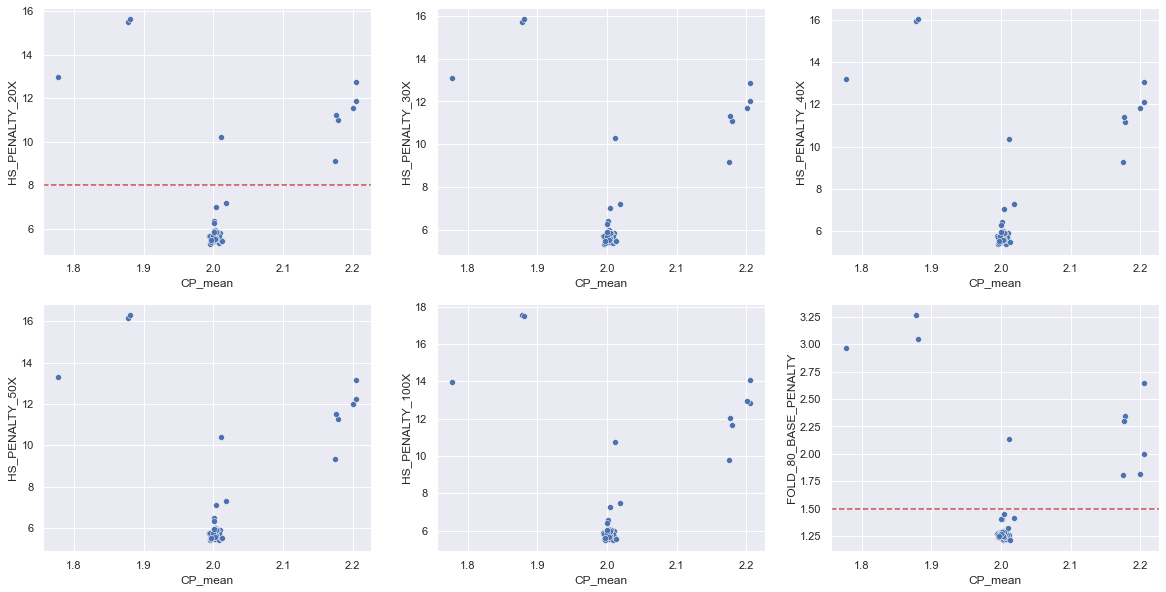

In [43]:
sns.set()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,10)
sns.scatterplot(ax=axs[0,0],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_20X)
sns.scatterplot(ax=axs[0,1],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_30X)
sns.scatterplot(ax=axs[0,2],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_40X)
sns.scatterplot(ax=axs[1,0],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_50X)
sns.scatterplot(ax=axs[1,1],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_100X)
sns.scatterplot(ax=axs[1,2],data=combinedALL,x=combinedALL.CP_mean,y=combined.FOLD_80_BASE_PENALTY)

axs[1,2].axhline(y=1.5,color='r',linestyle='--')
axs[0,0].axhline(y=8,color='r',linestyle='--')

In [119]:
per_chrom = pd.DataFrame()

for chrom in range(1,23):
    tmp = gcnv_124_all[gcnv_124_all['chr'] == str(chrom)].mean().drop(['chr','start','end']).to_frame(name=f'CP_mean_{chrom}')
    per_chrom = pd.concat([per_chrom,tmp],axis=1)
    #gcnv_124_all[gcnv_124_all['chr'] == str(chrom)].mean().drop(['chr','start','end']).to_frame(name=f'CP_mean_{chrom}')

x = gcnv_124_all[gcnv_124_all['chr'] == 'X'].mean().drop(['start','end']).to_frame(name='CP_mean_X')
per_chrom = pd.concat([per_chrom,x],axis=1)
per_chrom


/tmp/ipykernel_346671/2945127983.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x = gcnv_124_all[gcnv_124_all['chr'] == 'X'].mean().drop(['start','end']).to_frame(name='CP_mean_X')


,CP_mean_1,CP_mean_2,CP_mean_3,CP_mean_4,CP_mean_5,CP_mean_6,CP_mean_7,CP_mean_8,CP_mean_9,CP_mean_10,...,CP_mean_14,CP_mean_15,CP_mean_16,CP_mean_17,CP_mean_18,CP_mean_19,CP_mean_20,CP_mean_21,CP_mean_22,CP_mean_X
X221539-GM1610658-1-CEN-M-EGG5,2.011589,1.963731,2.038037,1.997294,1.972674,2.063186,2.003694,2.085895,2.044692,1.969419,...,2.012507,2.007063,2.052323,1.972264,2.094501,2.103816,2.165077,1.975286,2.047255,1.022878
X221543-GM1701755-1-CEN-F-EGG5,2.001854,2.015280,1.954010,2.002522,2.050614,2.121848,1.953548,2.001312,2.088239,2.010014,...,1.918200,2.014531,2.059636,1.980028,2.033604,1.996164,2.055141,1.983062,2.070070,1.979582
X221505-GM1401654-1-CEN-M-EGG5,2.039085,2.034890,2.060833,2.049914,2.017192,2.055402,2.035360,2.014840,2.623999,2.038381,...,1.999029,1.980521,2.960362,2.070973,1.936054,2.998463,2.906112,2.061832,1.969562,0.969560
X221491-GM1112489-1-CEN-F-EGG5,2.033927,2.019821,2.041847,2.045284,2.032689,2.035119,2.041849,2.014224,2.347357,2.045844,...,2.048496,1.995788,2.926484,2.000934,1.999834,2.983963,3.016221,2.021724,2.038984,1.897874
X221512-GM1414267-1-CEN-F-EGG5,2.038697,1.026109,2.018247,2.043468,1.029822,1.070721,2.047607,1.157431,2.330501,2.007266,...,1.995955,2.030380,2.989223,2.021029,1.021225,3.026333,2.984016,1.999042,1.044810,1.024449
X221508-GM1406304-1-CEN-F-EGG5,2.016356,1.029105,2.049251,2.027557,1.026530,1.064156,2.022044,1.172872,2.491636,2.019501,...,2.050245,1.995957,2.965735,2.028050,1.037231,3.003004,3.003935,2.058508,1.043385,1.046423
X221577-GM1818200-1-CEN-F-EGG5,1.993963,2.003302,2.005278,1.991474,2.008231,2.000956,1.993186,1.997563,1.994603,2.008381,...,1.999846,1.980870,1.990088,2.015596,1.996678,2.004760,1.993701,2.024492,2.018795,2.010880
X221533-GM1601267-1-CEN-F-EGG5,2.047463,2.013885,2.018020,2.030120,2.001085,1.997043,2.032440,2.030056,2.491139,2.015049,...,2.011664,2.047229,2.972574,2.049500,2.051506,2.971414,2.903912,2.026979,1.959159,1.918746
X221590-GM1905799-1-CEN-F-EGG5,2.028205,1.064539,1.872568,1.815405,1.105659,1.300269,1.852044,1.280222,1.934415,1.982130,...,1.936072,1.922523,2.325527,1.957659,1.107792,2.533178,2.403166,1.875789,1.270129,1.075659
X221595-GM1907328-1-CEN-F-EGG5,1.983089,1.998225,2.003272,2.013998,1.978265,1.988418,2.020422,1.993103,1.982183,1.995795,...,2.002000,2.004801,1.980047,2.017303,2.001204,1.995815,1.975914,2.001546,1.975832,1.986483


In [120]:
chr_combined=per_chrom.join(subset124, how='inner')
chr_combined

,CP_mean_1,CP_mean_2,CP_mean_3,CP_mean_4,CP_mean_5,CP_mean_6,CP_mean_7,CP_mean_8,CP_mean_9,CP_mean_10,...,CP_mean_20,CP_mean_21,CP_mean_22,CP_mean_X,FOLD_80_BASE_PENALTY,HS_PENALTY_20X,HS_PENALTY_30X,HS_PENALTY_40X,HS_PENALTY_50X,HS_PENALTY_100X
X221539-GM1610658-1-CEN-M-EGG5,2.011589,1.963731,2.038037,1.997294,1.972674,2.063186,2.003694,2.085895,2.044692,1.969419,...,2.165077,1.975286,2.047255,1.022878,2.140503,10.221137,10.285979,10.355809,10.409678,10.756834
X221543-GM1701755-1-CEN-F-EGG5,2.001854,2.015280,1.954010,2.002522,2.050614,2.121848,1.953548,2.001312,2.088239,2.010014,...,2.055141,1.983062,2.070070,1.979582,1.413743,7.186200,7.228022,7.264616,7.292846,7.493589
X221505-GM1401654-1-CEN-M-EGG5,2.039085,2.034890,2.060833,2.049914,2.017192,2.055402,2.035360,2.014840,2.623999,2.038381,...,2.906112,2.061832,1.969562,0.969560,2.643749,11.886306,12.001847,12.094279,12.223685,12.852226
X221491-GM1112489-1-CEN-F-EGG5,2.033927,2.019821,2.041847,2.045284,2.032689,2.035119,2.041849,2.014224,2.347357,2.045844,...,3.016221,2.021724,2.038984,1.897874,2.344393,10.987352,11.075903,11.164453,11.253003,11.678045
X221512-GM1414267-1-CEN-F-EGG5,2.038697,1.026109,2.018247,2.043468,1.029822,1.070721,2.047607,1.157431,2.330501,2.007266,...,2.984016,1.999042,1.044810,1.024449,3.261090,15.510974,15.733309,15.945977,16.189578,17.535187
X221508-GM1406304-1-CEN-F-EGG5,2.016356,1.029105,2.049251,2.027557,1.026530,1.064156,2.022044,1.172872,2.491636,2.019501,...,3.003935,2.058508,1.043385,1.046423,3.048774,15.643647,15.859470,16.062598,16.291117,17.479414
X221577-GM1818200-1-CEN-F-EGG5,1.993963,2.003302,2.005278,1.991474,2.008231,2.000956,1.993186,1.997563,1.994603,2.008381,...,1.993701,2.024492,2.018795,2.010880,1.247197,5.514101,5.528645,5.546824,5.557732,5.662445
X221533-GM1601267-1-CEN-F-EGG5,2.047463,2.013885,2.018020,2.030120,2.001085,1.997043,2.032440,2.030056,2.491139,2.015049,...,2.903912,2.026979,1.959159,1.918746,2.302142,11.211654,11.305637,11.399620,11.493604,12.044971
X221590-GM1905799-1-CEN-F-EGG5,2.028205,1.064539,1.872568,1.815405,1.105659,1.300269,1.852044,1.280222,1.934415,1.982130,...,2.403166,1.875789,1.270129,1.075659,2.960702,12.969212,13.075714,13.201580,13.323573,13.950965
X221595-GM1907328-1-CEN-F-EGG5,1.983089,1.998225,2.003272,2.013998,1.978265,1.988418,2.020422,1.993103,1.982183,1.995795,...,1.975914,2.001546,1.975832,1.986483,1.276727,5.616548,5.628762,5.653191,5.667849,5.770450


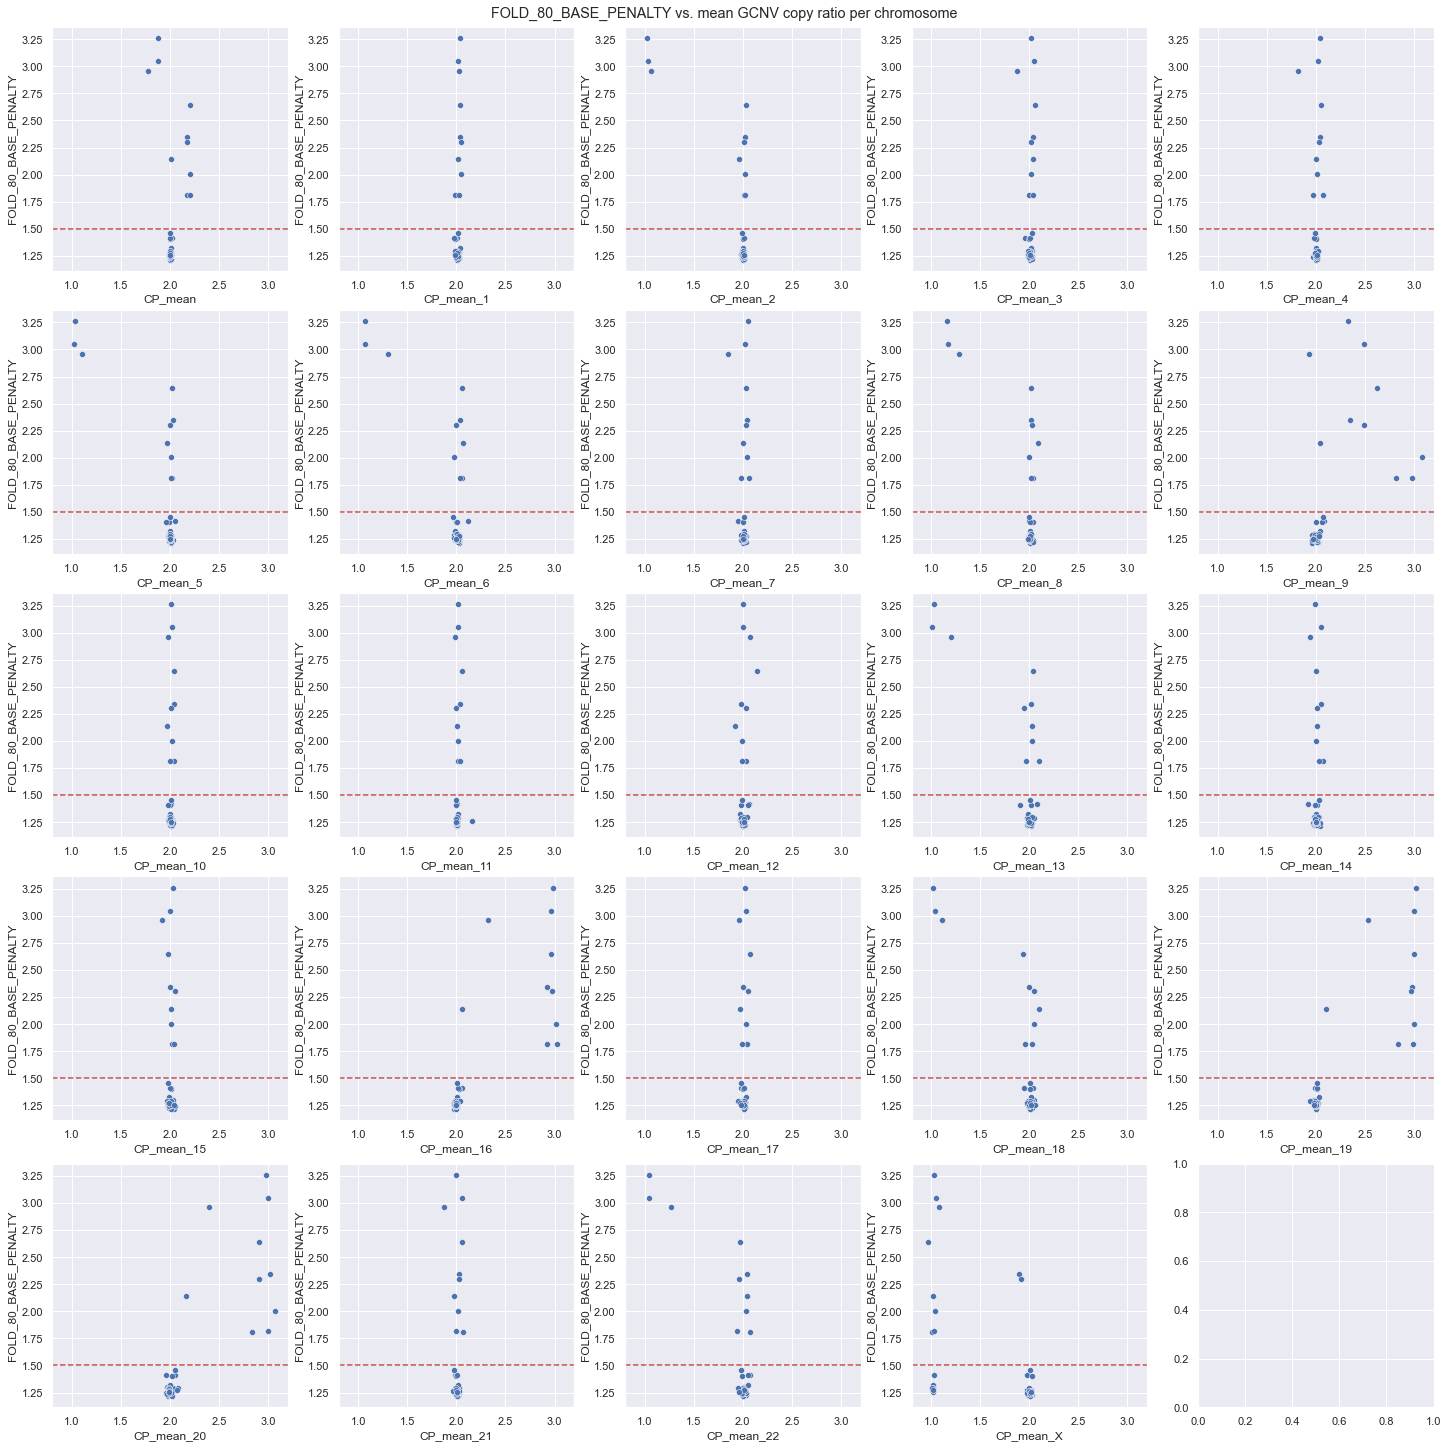

In [127]:
'''
sns.set()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,10)
sns.scatterplot(ax=axs[0,0],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_20X)
sns.scatterplot(ax=axs[0,1],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_30X)
sns.scatterplot(ax=axs[0,2],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_40X)
sns.scatterplot(ax=axs[1,0],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_50X)
sns.scatterplot(ax=axs[1,1],data=combinedALL,x=combinedALL.CP_mean,y=combined.HS_PENALTY_100X)
sns.scatterplot(ax=axs[1,2],data=combinedALL,x=combinedALL.CP_mean,y=combined.FOLD_80_BASE_PENALTY)

axs[1,2].axhline(y=1.5,color='r',linestyle='--')
axs[0,0].axhline(y=8,color='r',linestyle='--')

'''

chr_index = [str(i) for i in range(1, 23)]


fig, axs = plt.subplots(
        nrows=5,
        ncols=5,
        figsize=(20, 20),
        constrained_layout=True
    )

#axs.set_xlim(0.8,3.2)
fig.suptitle('FOLD_80_BASE_PENALTY vs. mean GCNV copy ratio per chromosome')

for i in range(1,23):

    # choose first row, iterate over all columns, go to next row etc.
    row_index = i // 5 # row index will be 0, 0, 0, 0, 1, 1, 1, 1 etc.
    col_index = i % 5  # col index will be 0, 1, 2, 3, 0, 1, 2, 3 etc.
    #print (row_index, col_index)
    # select plot
    #ax = axs[row_index,col_index]

    sns.scatterplot(ax=axs[row_index,col_index],data=chr_combined,x=chr_combined[f'CP_mean_{i}'],y=chr_combined.FOLD_80_BASE_PENALTY)
    axs[row_index,col_index].axhline(y=1.5,color='r',linestyle='--')
    axs[row_index,col_index].set_xlim(0.8,3.2)

sns.scatterplot(ax=axs[0,0],data=combinedALL,x=combinedALL.CP_mean,y=combined.FOLD_80_BASE_PENALTY)
axs[0,0].axhline(y=1.5,color='r',linestyle='--')
axs[0,0].set_xlim(0.8,3.2)


sns.scatterplot(ax=axs[4,3],data=chr_combined,x=chr_combined['CP_mean_X'],y=chr_combined.FOLD_80_BASE_PENALTY)
axs[4,3].axhline(y=1.5,color='r',linestyle='--')
axs[4,3].set_xlim(0.8,3.2)

plt.savefig('221130_A01303_0124_AHMTC5DRX2_CEN_copy_ratios-per_chrom_fold80.png')